# Lab Assignment Four: Multi-Layer Perceptron

CS 7324

2021-04-07

Anthony Wang

## Load, Split, and Balance

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

dataframe = pd.read_csv("acs2017_census_tract_data.csv")
dataframe.dropna(inplace=True)

del dataframe['TractId']
encoder = LabelEncoder()
dataframe['State'] = encoder.fit_transform(dataframe['State'])
dataframe['County'] = encoder.fit_transform(dataframe['County'])

print(dataframe.info())
print(dataframe.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int32  
 1   County            72718 non-null  int32  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6

In [2]:
from sklearn.model_selection import train_test_split

def split_dataframe(dataframe):
    copy = dataframe.copy()
    y = copy['ChildPoverty'].values
    del copy['ChildPoverty']
    X = copy.to_numpy()
    return train_test_split(X, y, test_size=0.2)

In [3]:
cutoffs = [100]
for i in range(4):
    cutoffs.insert(-1, dataframe['ChildPoverty'].quantile(i/4))
print(cutoffs)

dataframe['ChildPoverty'] = pd.cut(
    dataframe['ChildPoverty'],
    cutoffs,
    right=True,
    include_lowest=True,
    labels=[
        'Low Poverty',
        'Mild Poverty',
        'Moderate Poverty',
        'Extreme Poverty'
    ]
)

print()
print(dataframe['ChildPoverty'].value_counts())
dataframe['ChildPoverty'] = dataframe['ChildPoverty'].factorize()[0]

[0.0, 6.2, 16.3, 31.6, 100]

Low Poverty         18229
Mild Poverty        18171
Extreme Poverty     18170
Moderate Poverty    18148
Name: ChildPoverty, dtype: int64


Balancing should not be done for both the training and testing set. It is performed on the training data to make training easier and avoid overclassification. Balancing the testing set may be counterproductive as real data may not follow the same distribution as the testing data.

## Pre-processing

### Defining the perceptron

In [4]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [5]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx], self.W1, self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [6]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [7]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

### Training of perceptron

In [8]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print()
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

vals = {
    'n_hidden': 30, 
    'C': 0.1,
    'epochs': 20,
    'eta': 0.001,
    'alpha': 0.001,
    'minibatches': 50,
    'shuffle': True,
    'random_state': 1
}

#### Using data as is

Epoch: 20/20
Unprocessed Data :
Resubstitution acc: 0.2515384879843229
Validation acc: 0.24724972497249725


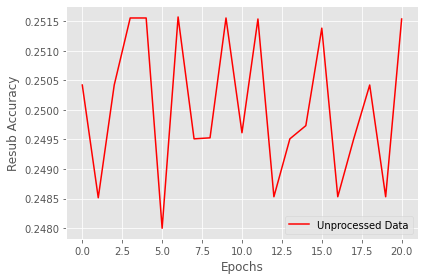

In [9]:
X_train, X_test, y_train, y_test = split_dataframe(dataframe)
nn = TLPBetterInitial(**vals)
nn.fit(X_train, y_train, print_progress=True)
e = 1 - accuracy_score(y_test, nn.predict(X_test))

print_result(nn, X_train, y_train, X_test, y_test, title="Unprocessed Data")

#### Using normalized data

Epoch: 20/20
Normalized Data :
Resubstitution acc: 0.2545295149035652
Validation acc: 0.24979372937293728


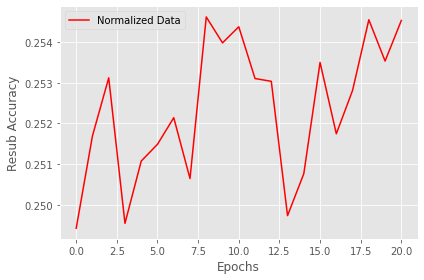

In [10]:
from sklearn.preprocessing import StandardScaler

for column in dataframe.columns:
    normalizer = StandardScaler()
    # State and county are not ordinal data, therefore there
    # is no normalization to perform on those columns.
    if column != 'State' and column != 'County' and column != 'ChildPoverty':
        dataframe[column] = dataframe[column].astype('float64')
        dataframe[column] = normalizer.fit_transform(dataframe[column].values.reshape(-1, 1))



X_train, X_test, y_train, y_test = split_dataframe(dataframe)
nn_normalized = TLPBetterInitial(**vals)
nn_normalized.fit(X_train, y_train, print_progress=True)
e_norm = 1 - accuracy_score(y_test, nn_normalized.predict(X_test))

print_result(nn_normalized, X_train, y_train, X_test, y_test, title="Normalized Data")

#### Using normalized and encoded data

Epoch: 20/20
Normalized and Encoded Data :
Resubstitution acc: 0.7298793275346375
Validation acc: 0.7204345434543454


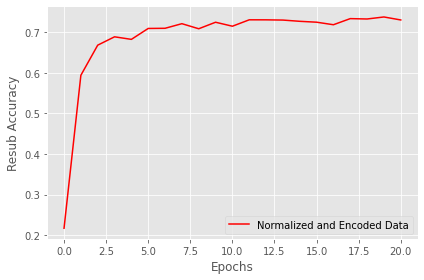

In [11]:
dataframe = pd.concat((dataframe, pd.get_dummies(dataframe['State'], prefix='State')), axis=1)
del dataframe['State']
dataframe = pd.concat((dataframe, pd.get_dummies(dataframe['County'], prefix='County')), axis=1)
del dataframe['County']



X_train, X_test, y_train, y_test = split_dataframe(dataframe)
nn_normalized_encoded = TLPBetterInitial(**vals)
nn_normalized_encoded.fit(X_train, y_train, print_progress=True)
e_norm_ohe = 1 - accuracy_score(y_test, nn_normalized_encoded.predict(X_test))

print_result(nn_normalized_encoded, X_train, y_train, X_test, y_test, title="Normalized and Encoded Data")

#### Comparison between models

Cursory comparison of accuracies and visual inspection of the epoch curves show that the model trained on normalized and one-hot encoded data is far superior to models trained on data that has not been pre-processed in such a manner. However, statistical comparison will be performed to identify and quantify differences between each. Approximating the error rates using normal distributions allows variance can be easily estimated. In conjunction with the mean difference, the estimated variance can be used to determine whether one model is better than another to a certain confidence level.

In the following calculations, each model's validation accuracy is used to determine error rate. It can be said with 99.9% confidence that the model trained and tested on normalized and one-hot encoded data significantly outperforms the other models.

In [21]:
from math import sqrt

def different(e1, n1, e2, n2, z):
    mean = abs(e2 - e1)
    variance = e1 * (1 - e1) / n1 + e2 * (1 - e2) / n2
    lower_bound = mean - z * sqrt(variance)
    upper_bound = mean + z * sqrt(variance)
    if lower_bound < 0 and upper_bound > 0:
        return False
    else:
        return True



n = len(y_test)

print("Models 1 and 2", "are" if different(e, n, e_norm, n, 1.96) else "are not", "different with 95% confidence.")
print("Models 2 and 3", "are" if different(e_norm, n, e_norm_ohe, n, 3.29) else "are not", "different with 99.9% confidence.")
print("Models 1 and 3", "are" if different(e, n, e_norm_ohe, n, 3.29) else "are not", "different with 99.9% confidence.")

Models 1 and 2 are not different with 95% confidence.
Models 2 and 3 are different with 99.9% confidence.
Models 1 and 3 are different with 99.9% confidence.


## Modeling

Much of the following code is adapted from the perceptron used in the previous section.

In [13]:
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

class MultiLayerPerceptron:
    def __init__(
        self,
        num_layers=2,
        n_hidden=[30],
        C=0.0,
        epochs=500,
        eta=0.001,
        random_state=None,
        alpha=0.0,
        decrease_const=0.0,
        shuffle=True,
        minibatches=1
    ):
        np.random.seed(random_state)
        self.num_layers = num_layers
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.n_hidden = n_hidden
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new    

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)    

    @staticmethod
    def _L2_reg(lambda_, num_layers, W):
        sum = 0
        for w in W:
            sum += np.mean(w[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(sum)

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        W = []

        init_bound = 4*np.sqrt(6. / (self.n_hidden[0] + self.n_features_ + 1))
        w = np.random.uniform(-init_bound, init_bound,(self.n_hidden[0], self.n_features_ + 1))
        w[:,:1] = 0
        W.append(w)

        for i in range(1, self.num_layers - 1):
            init_bound = 4*np.sqrt(6 / (self.n_hidden[i] + self.n_hidden[i-1] + 1))
            w = np.random.uniform(-init_bound, init_bound,(self.n_hidden[i], self.n_hidden[i-1] + 1))
            w[:,:1] = 0
            W.append(w)

        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden[self.num_layers-2] + 1))
        w = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden[self.num_layers-2] + 1))
        w[:,:1] = 0
        W.append(w)

        W = np.asarray(W)
        return W

    def _cost(self, LastA, Y_enc, W):
        """Get the objective function value"""
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(LastA)+(1-Y_enc)*np.log(1-LastA))))
        L2_term = self._L2_reg(self.C, self.num_layers, W)
        return cost + L2_term

    def _feedforward(self, X, W):
        """Compute feedforward step"""
        A = []
        Z = []

        a = self._add_bias_unit(X.T, how='row')
        A.append(a)

        for i in range(self.num_layers - 1):
            Z.append(W[i] @ A[i])
            a = self._sigmoid(Z[i])
            a = self._add_bias_unit(a, how='row')
            A.append(a)
            
        Z.append(W[len(W) - 1] @ A[len(A) - 1])
        A.append(self._sigmoid(Z[len(Z) - 1]))
            
        return A, Z

    def _get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation."""
        Vfinal = (A[len(A)-1] - Y_enc)
        Vprev = Vfinal
        g = (Vfinal @ A[len(A)-2].T)
        g[:, 1:] += W[len(W)-1][:, 1:] * self.C
        grad = [g]
                
        for i in range(1, self.num_layers - 1):
            V = A[len(A)-i-1]*(1 - A[len(A)-i-1]) * (W[len(W)-i].T @ Vprev)
            Vprev = V[1:,:] #if (i == 0) else V
            g = V[1:,:] @ A[len(A)-i-2].T
            g[:, 1:] += W[len(W)-i-1][:, 1:] * self.C
            grad.insert(0, g)
            
        V = A[1]*(1 - A[1]) * (W[1].T @ Vprev)
        g = V[1:,:] @ A[0].T
        g[:, 1:] += W[0][:, 1:] * self.C
        grad.insert(0, g)

        return grad

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        delta_W_prev = []
        for weight in self.W:
            delta_W_prev.append(np.zeros(weight.shape))

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))

        self.grad_w_ = []
        for i in range(self.num_layers):
            self.grad_w_.append([])

        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()        

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
      
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            gradients = [0 for index in range(self.num_layers)]
            for idx in mini:
                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[len(A) - 1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)
                for j in range(self.num_layers):
                    gradients[j] += np.mean(grad[j])

                # momentum calculations
                delta_W = [g * self.eta for g in grad]
                for j in range(len(delta_W)):
                    self.W[j] -= (delta_W[j] + (self.alpha * delta_W_prev[j]))
                
                delta_W_prev = delta_W

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))

            for j in range(len(self.grad_w_)):
                self.grad_w_[j].append(gradients[j])

        return self

    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[self.num_layers], axis=0)
        return y_pred

In [14]:
from matplotlib import pyplot
import seaborn

def plot_gradients(nn, num_layers):
    pyplot.figure()
    pyplot.subplots(figsize=(15, 5 * num_layers))
    pyplot.tight_layout()
    pyplot.suptitle(f'Gradient Magnitudes for {num_layers} Layer Perceptron During Training')
    for i in range(num_layers):
        pyplot.subplot(num_layers, 1, i + 1)
        seaborn.lineplot(data=np.abs(nn.grad_w_[i])).set(xlabel='Epoch', title=f'Layer {i+1}', ylabel='Average Gradient Magnitude')

### Three Layer Model Training

Epoch: 20/20
3 Layer Perceptron :
Resubstitution acc: 0.7356722934644343
Validation acc: 0.7378300330033003


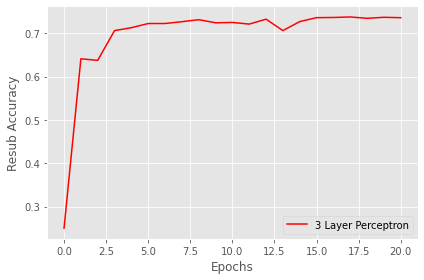

<Figure size 432x288 with 0 Axes>

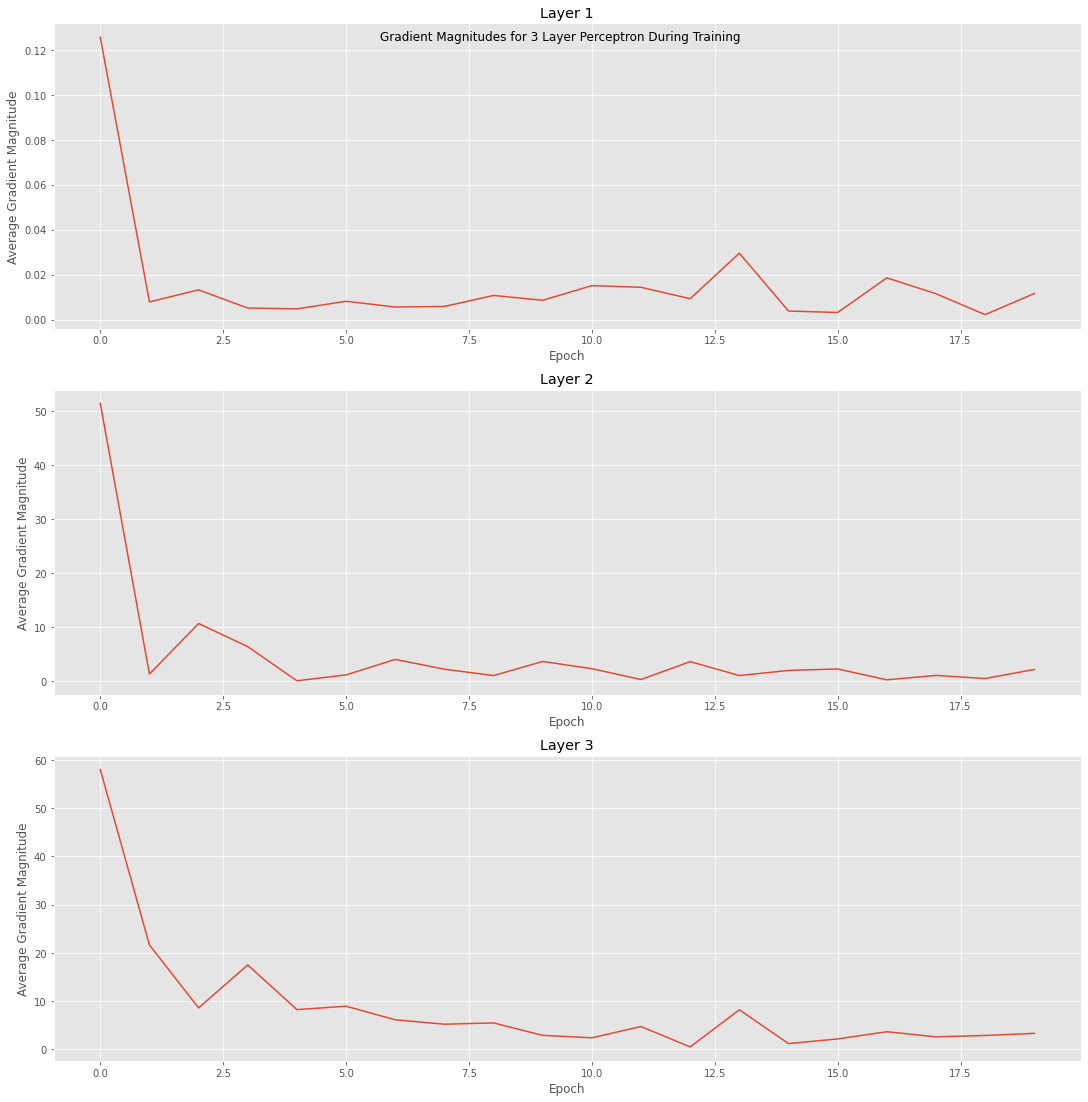

In [15]:
vals = {
    'num_layers': 3,
    'n_hidden': [30, 30], 
    'C': 0.01,
    'epochs': 20,
    'eta': 0.001,
    'random_state': 1,
    'shuffle': True,
    'minibatches': 50
}

X_train, X_test, y_train, y_test = split_dataframe(dataframe)
three_layer_model = MultiLayerPerceptron(**vals)
three_layer_model.fit(X_train, y_train, print_progress=True)
print_result(three_layer_model, X_train, y_train, X_test, y_test, title='3 Layer Perceptron')
plot_gradients(three_layer_model, 3)
e_3 = 1 - accuracy_score(y_test, three_layer_model.predict(X_test))

### Four Layer Model Training

Epoch: 20/20
4 Layer Perceptron :
Resubstitution acc: 0.7237081857874652
Validation acc: 0.7220159515951595


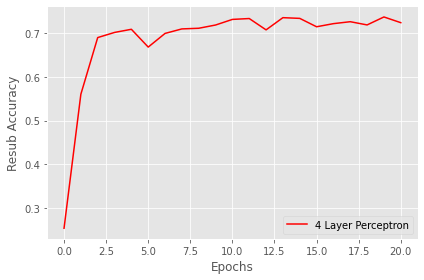

<Figure size 432x288 with 0 Axes>

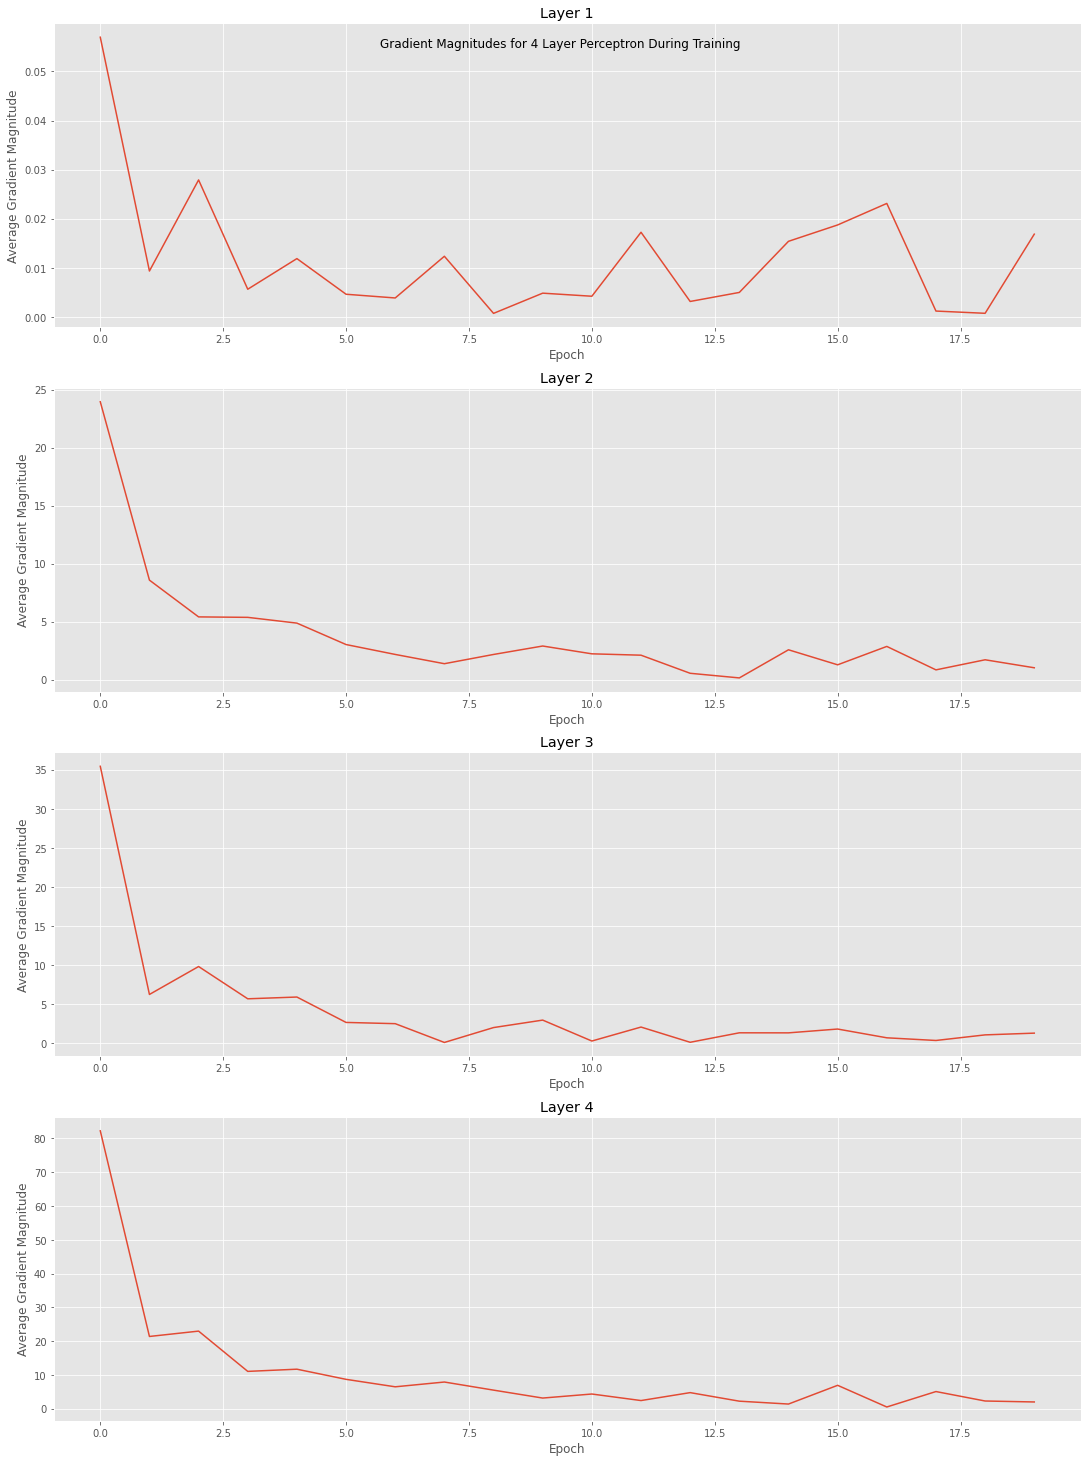

In [16]:
vals = {
    'num_layers': 4,
    'n_hidden': [30, 30, 30], 
    'C': 0.01,
    'epochs': 20,
    'eta': 0.001,
    'random_state': 1,
    'shuffle': True,
    'minibatches': 50
}

X_train, X_test, y_train, y_test = split_dataframe(dataframe)
four_layer_model = MultiLayerPerceptron(**vals)
four_layer_model.fit(X_train, y_train, print_progress=True)
print_result(four_layer_model, X_train, y_train, X_test, y_test, title='4 Layer Perceptron')
plot_gradients(four_layer_model, 4)
e_4 = 1 - accuracy_score(y_test, four_layer_model.predict(X_test))

### Five Layer Model Training

Epoch: 20/20
5 Layer Perceptron :
Resubstitution acc: 0.7313060817547358
Validation acc: 0.7277227722772277


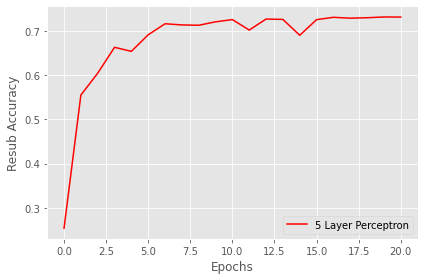

<Figure size 432x288 with 0 Axes>

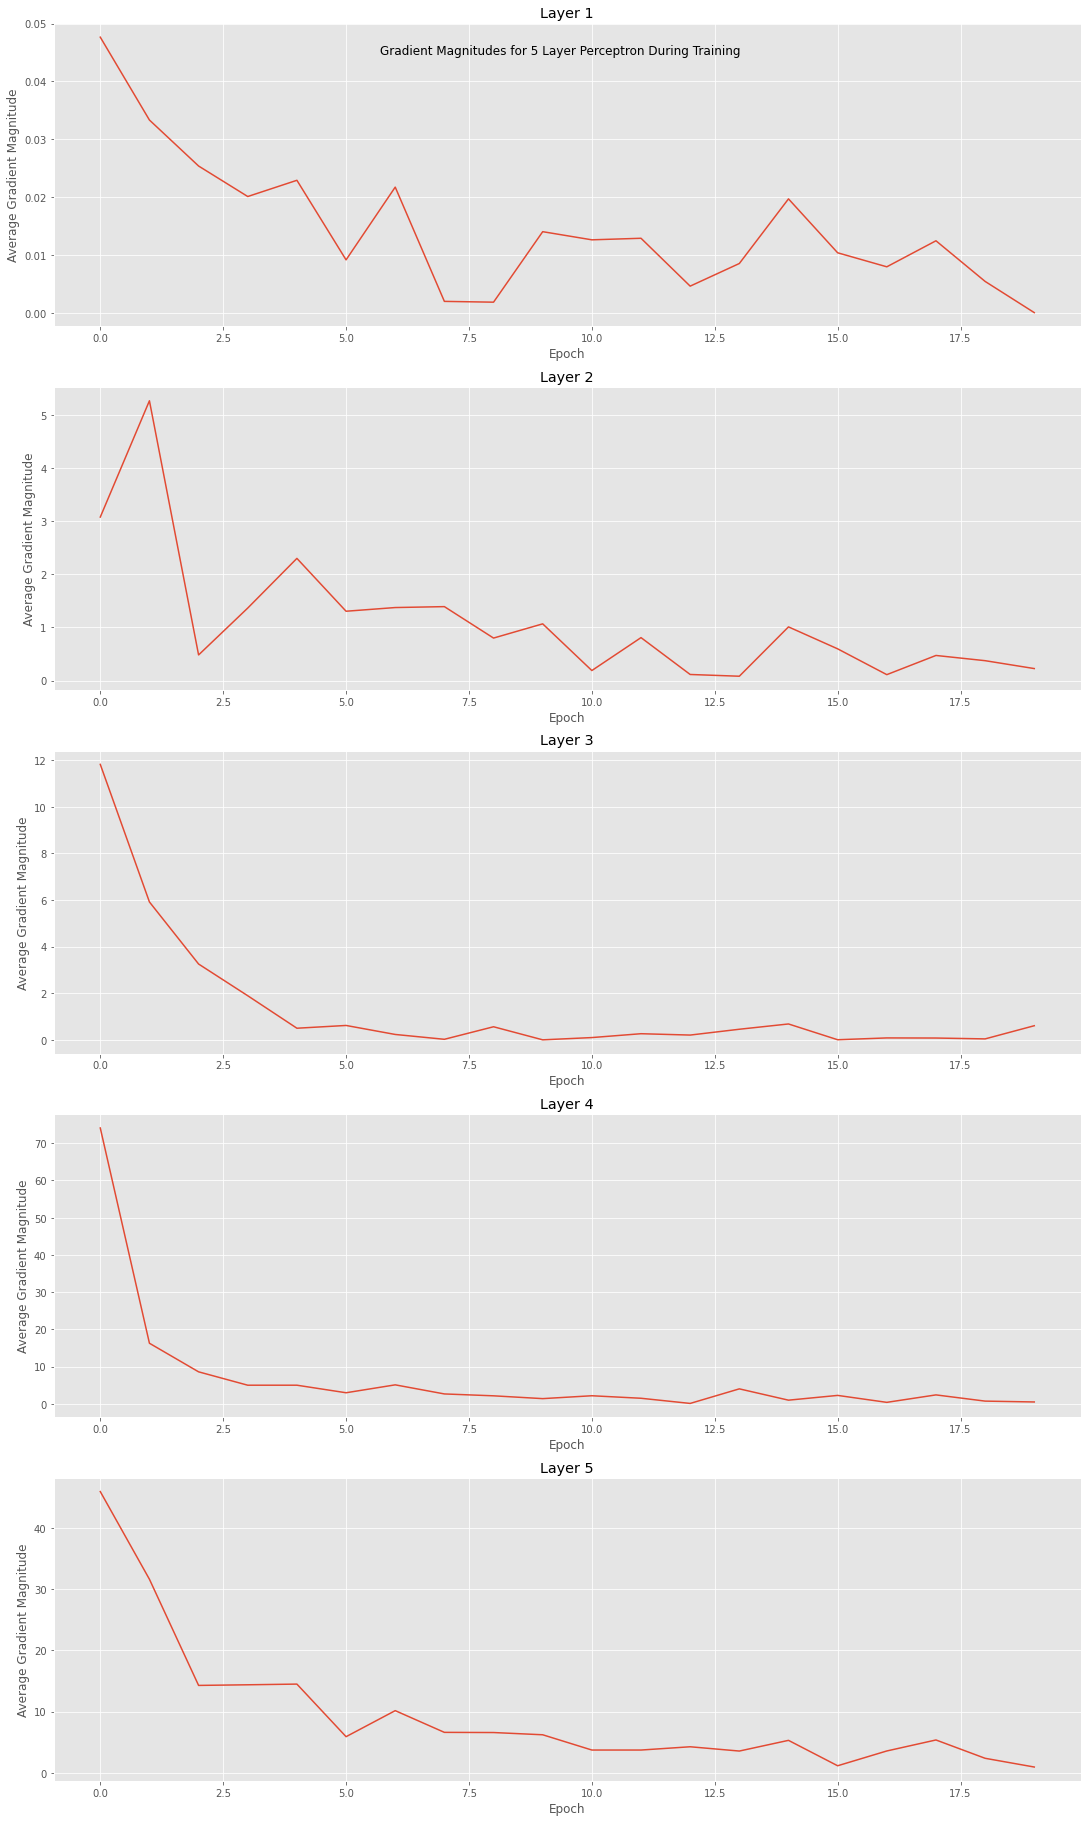

In [17]:
vals = {
    'num_layers': 5,
    'n_hidden': [30, 30, 30, 30], 
    'C': 0.01,
    'epochs': 20,
    'eta': 0.001,
    'random_state': 1,
    'shuffle': True,
    'minibatches': 50
}

X_train, X_test, y_train, y_test = split_dataframe(dataframe)
five_layer_model = MultiLayerPerceptron(**vals)
five_layer_model.fit(X_train, y_train, print_progress=True)
print_result(five_layer_model, X_train, y_train, X_test, y_test, title='5 Layer Perceptron')
plot_gradients(five_layer_model, 5)
e_5 = 1 - accuracy_score(y_test, five_layer_model.predict(X_test))

## Implementation of Cooling Learning Rate

A cooling learning rate strategy has been built into the `MultiLayerPerceptron` class, but has not yet been utilized. It can be used by providing a `decrease_const` parameter which will reduce eta by increasingly greater quantities as the model trains into later epochs. The same statistical analysis as before will be used to determine if the model performs significantly better with an adaptive learning rate.

Epoch: 20/20
Cooling 5 Layer Perceptron :
Resubstitution acc: 0.7270430089043215
Validation acc: 0.7263476347634763

The models without and with adaptive learning rate are not different with 95% confidence.


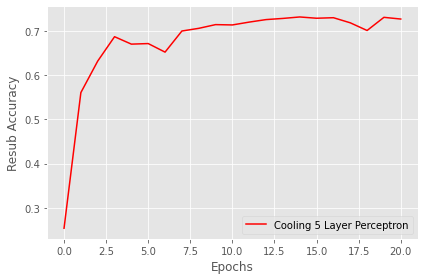

<Figure size 432x288 with 0 Axes>

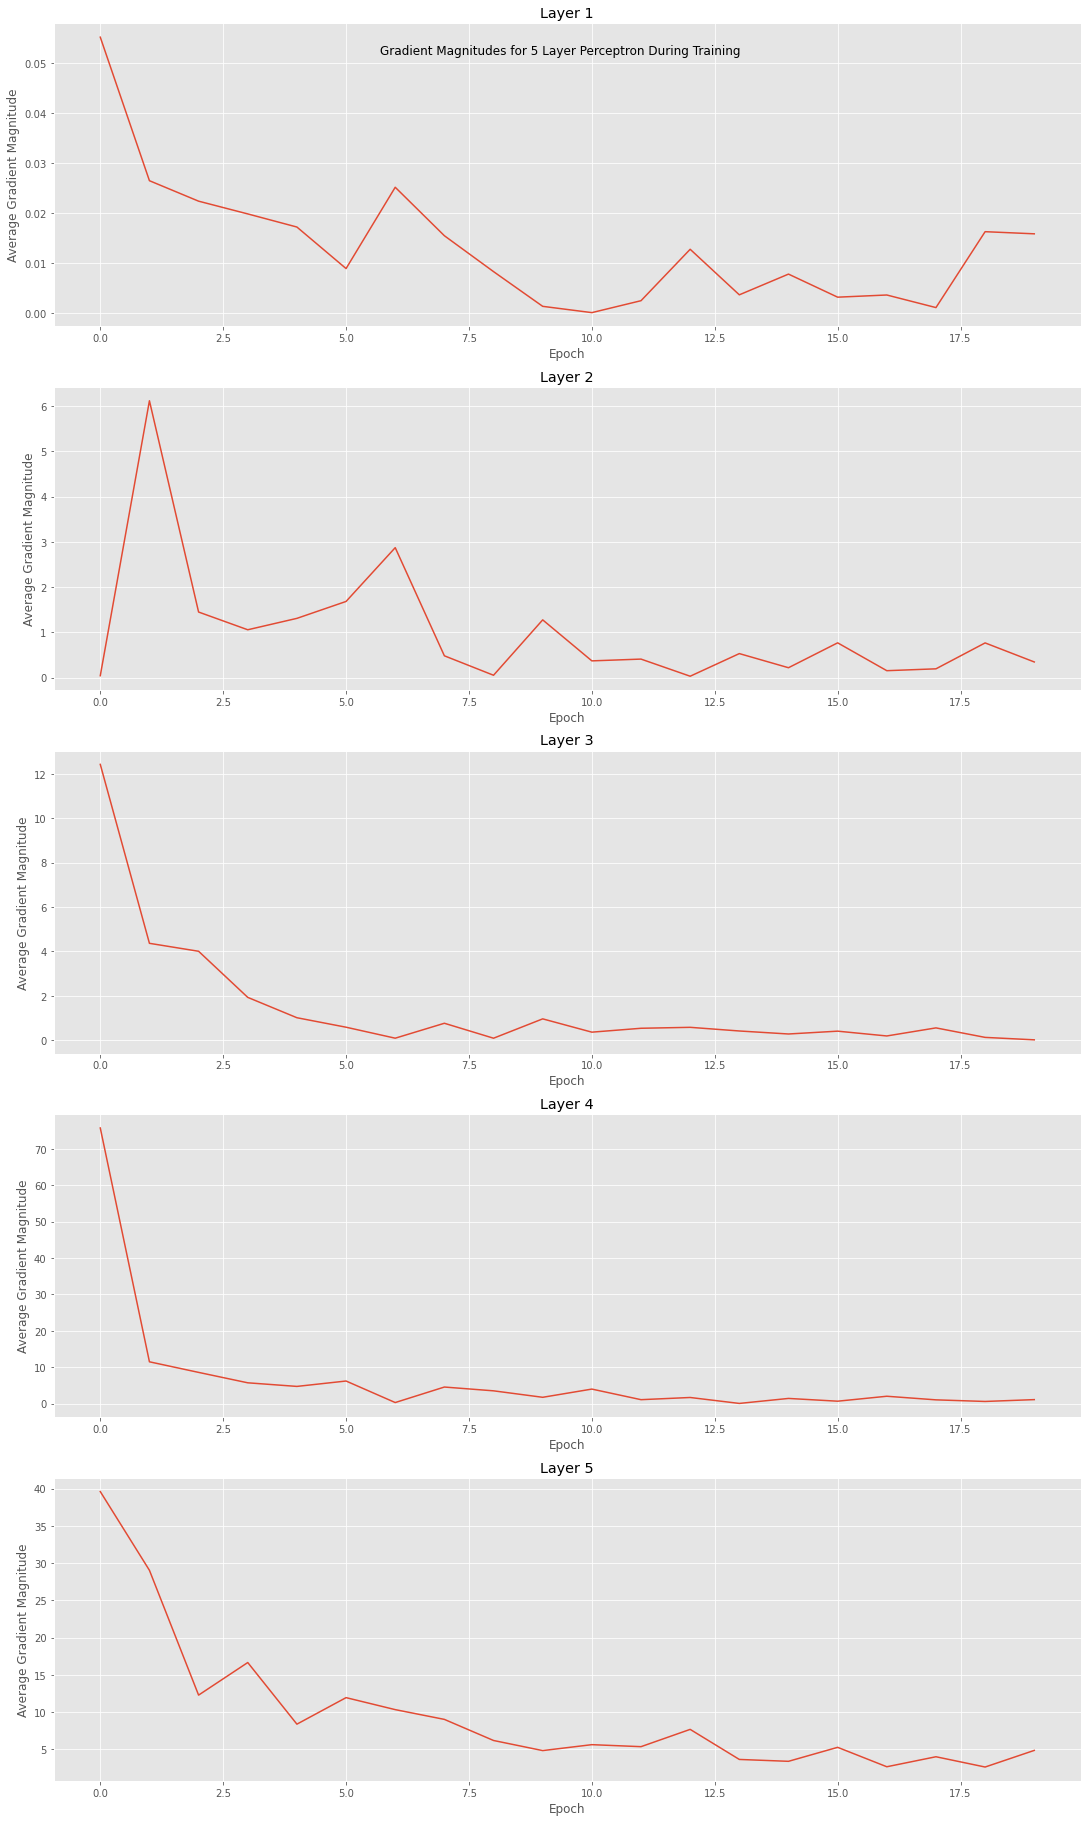

In [18]:
vals = {
    'num_layers': 5,
    'n_hidden': [30, 30, 30, 30], 
    'C': 0.01,
    'epochs': 20,
    'eta': 0.001,
    'random_state': 1,
    'shuffle': True,
    'minibatches': 50,
    'decrease_const': 1e-5
}

X_train, X_test, y_train, y_test = split_dataframe(dataframe)
adaptive_model = MultiLayerPerceptron(**vals)
adaptive_model.fit(X_train, y_train, print_progress=True)
print_result(adaptive_model, X_train, y_train, X_test, y_test, title='Cooling 5 Layer Perceptron')
plot_gradients(adaptive_model, 5)
e_cooling = 1 - accuracy_score(y_test, adaptive_model.predict(X_test))

print("\nThe models without and with adaptive learning rate", "are" if different(e_5, n, e_cooling, n, 1.96) else "are not", "different with 95% confidence.")

## Usage of Adaptive Momentum

As with the adaptive learning rate, adaptive momentum has been implemented and can be activated by passing an `alpha` parameter. This value determines how large the effect of each subsequent gradient will be on the model's existing momentum.

Epoch: 20/20
AdaM 5 Layer Perceptron :
Resubstitution acc: 0.7270430089043215
Validation acc: 0.7263476347634763

The model without any adaptive strategy and the model with adaptive learning rate and momentum are not different with 95% confidence.
The model with only a cooling learning rate and the model with both adaptive learning rate and momentum are not different with 95% confidence.


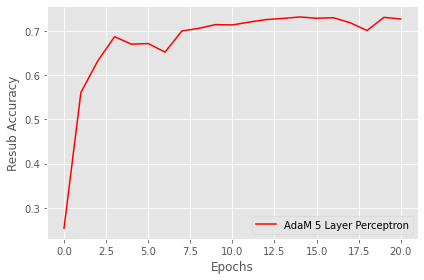

<Figure size 432x288 with 0 Axes>

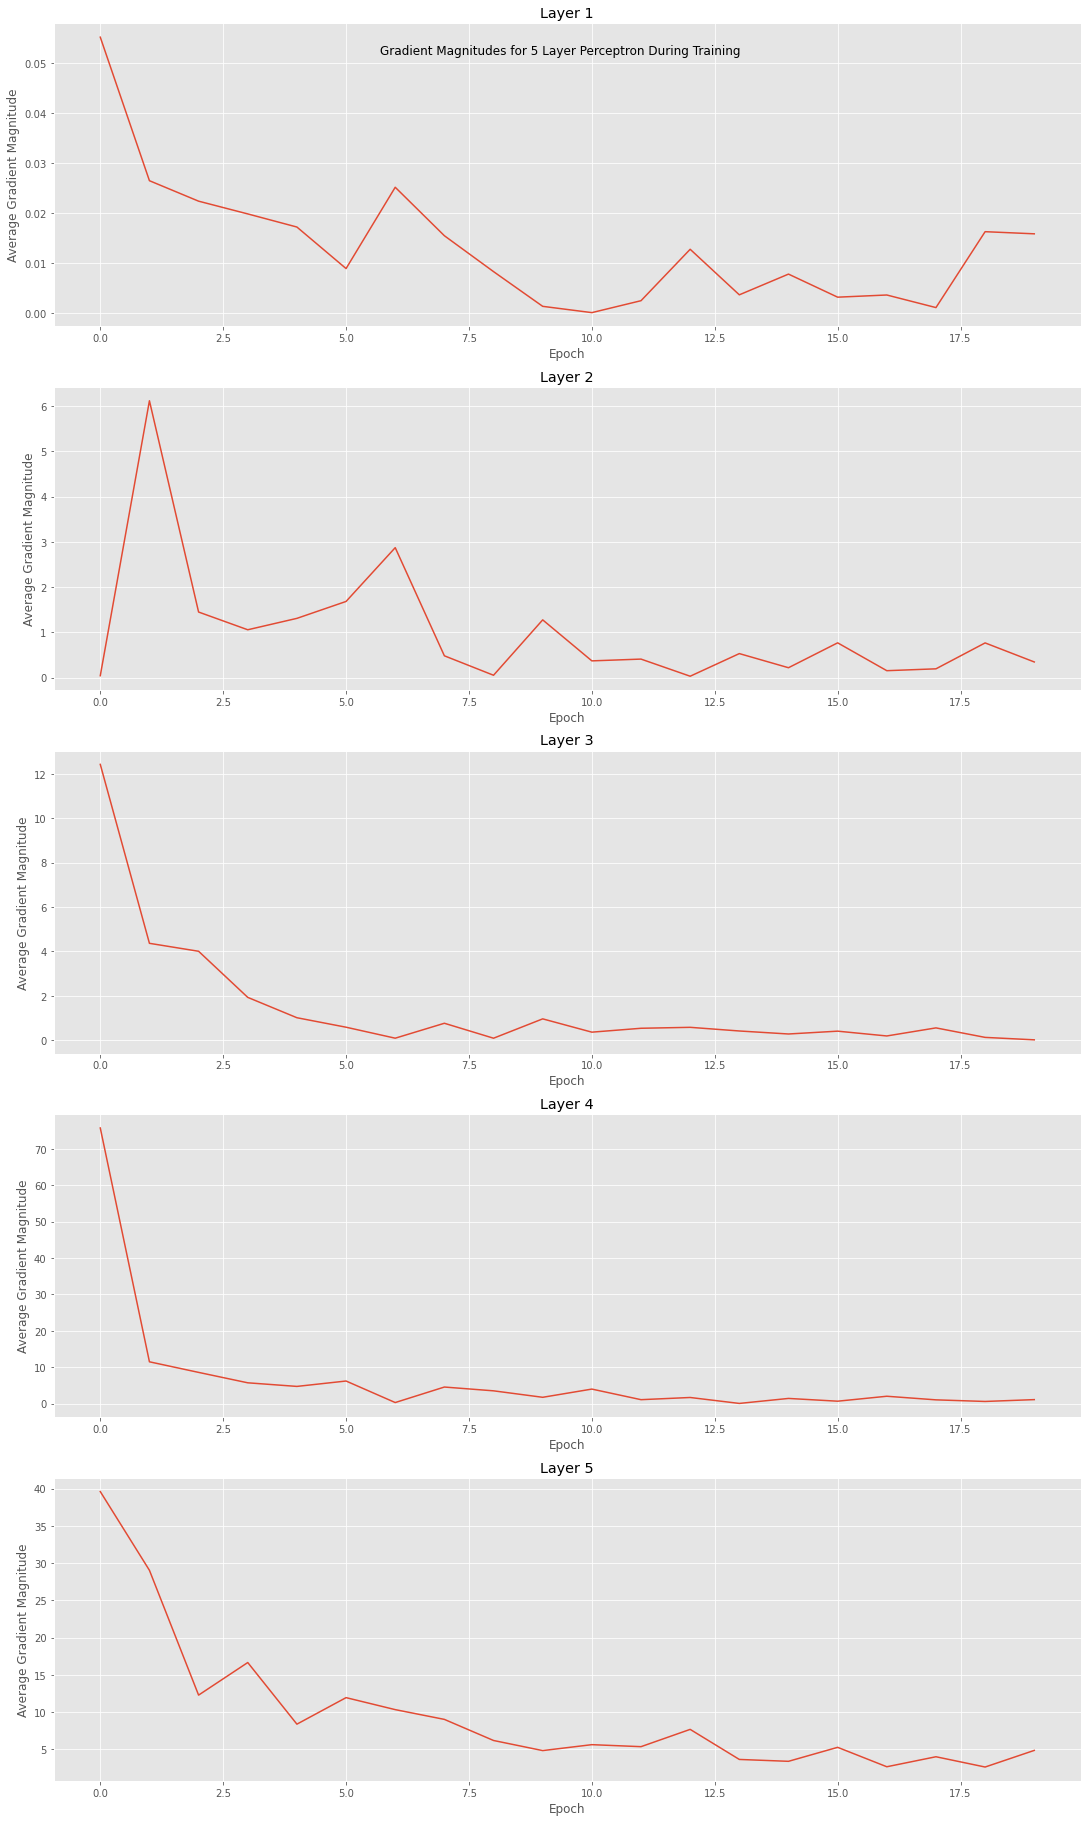

In [19]:
vals = {
    'num_layers': 5,
    'n_hidden': [30, 30, 30, 30], 
    'C': 0.01,
    'epochs': 20,
    'eta': 0.001,
    'random_state': 1,
    'shuffle': True,
    'minibatches': 50,
    'decrease_const': 1e-5,
    'alpha': .01
}

X_train, X_test, y_train, y_test = split_dataframe(dataframe)
adam_model = MultiLayerPerceptron(**vals)
adam_model.fit(X_train, y_train, print_progress=True)
print_result(adaptive_model, X_train, y_train, X_test, y_test, title='AdaM 5 Layer Perceptron')
plot_gradients(adaptive_model, 5)
e_cooling_adam = 1 - accuracy_score(y_test, adam_model.predict(X_test))

print("\nThe model without any adaptive strategy and the model with adaptive learning rate and momentum", "are" if different(e_5, n, e_cooling_adam, n, 1.96) else "are not", "different with 95% confidence.")
print("The model with only a cooling learning rate and the model with both adaptive learning rate and momentum", "are" if different(e_cooling, n, e_cooling_adam, n, 1.96) else "are not", "different with 95% confidence.")